In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import Planetoid

# Load the dataset
dataset = Planetoid(root='data/Cora', name='Cora')

# Extract the graph
data = dataset[0]

Processing...
Done!


In [3]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Train nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")


Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7
Train nodes: 140
Validation nodes: 500
Test nodes: 1000


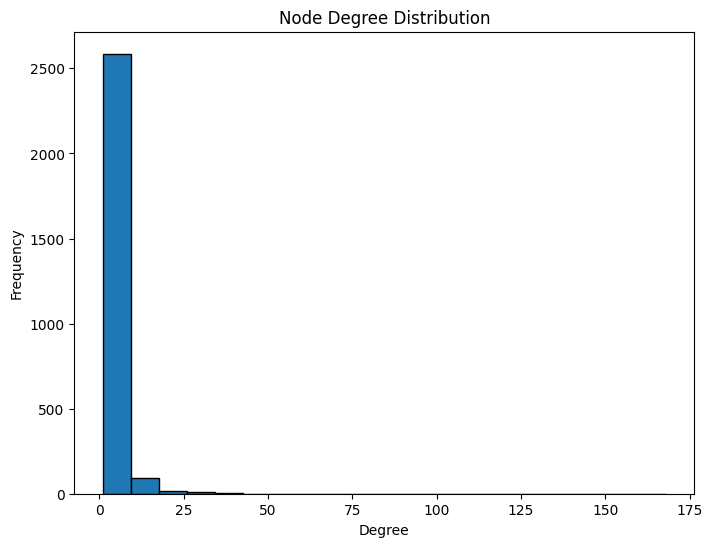

In [4]:
import matplotlib.pyplot as plt

from torch_geometric.utils import degree

# Compute degrees
degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(degrees.numpy(), bins=20, edgecolor="black")
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


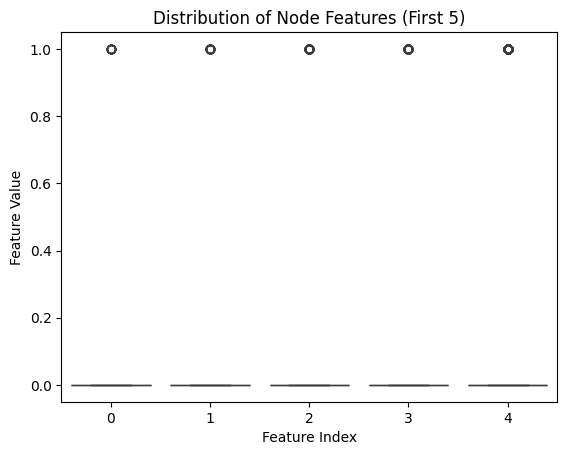

In [5]:
import seaborn as sns
import pandas as pd

# Convert features to a Pandas DataFrame for analysis
features_df = pd.DataFrame(data.x.numpy())

# Visualize feature distribution for a few features
sns.boxplot(data=features_df.iloc[:, :5])
plt.title("Distribution of Node Features (First 5)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()


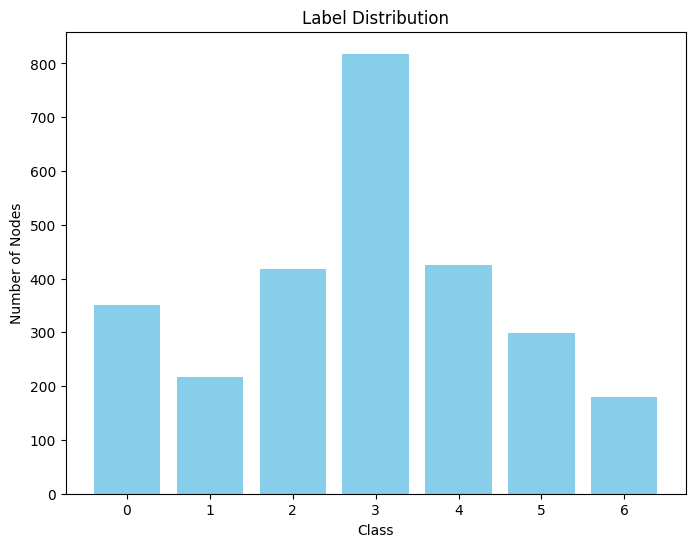

In [6]:
import numpy as np

labels = data.y.numpy()
unique, counts = np.unique(labels, return_counts=True)

# Plot label distribution
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, color='skyblue')
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Nodes")
plt.show()


KeyboardInterrupt: 

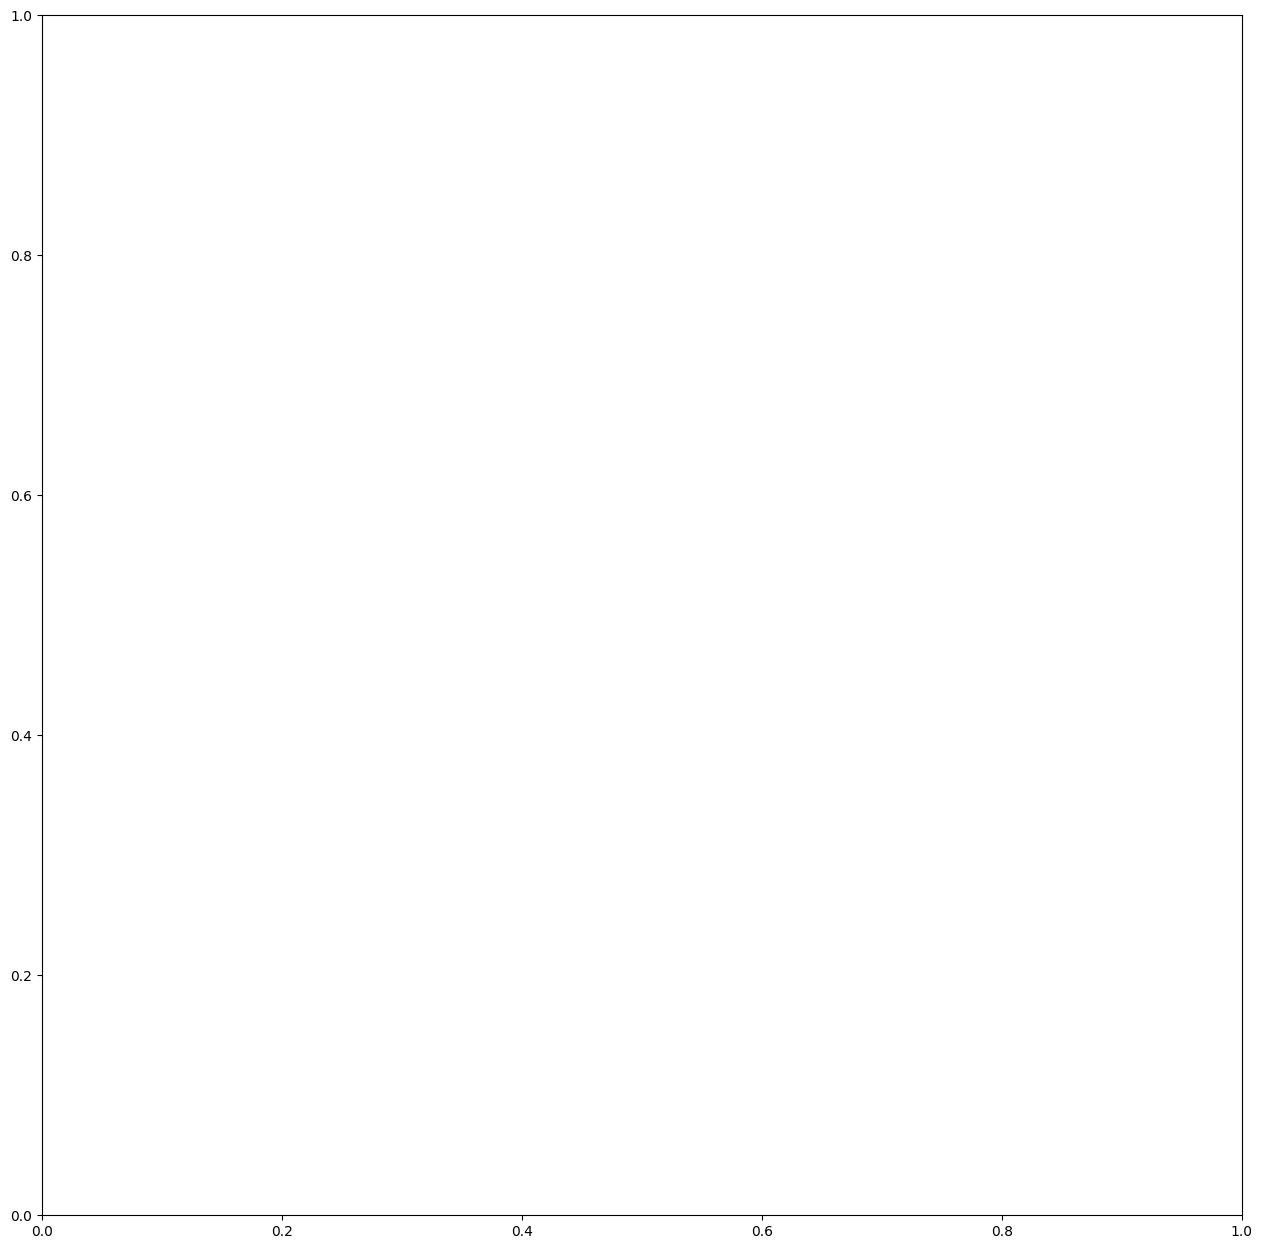

In [7]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Plot the graph with node labels as colors
plt.figure(figsize=(12, 12))
nx.draw(G, node_color=labels, cmap=plt.cm.tab10, node_size=50, with_labels=False)
plt.title("Cora Graph Visualization")
plt.show()

In [9]:
!pip install higher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

import higher

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='data/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

In [11]:
# ---------------------------
class META_GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second (final) graph convolution layer
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First layer + ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # Second layer (no activation – logits output)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = META_GNN(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

In [15]:
num_epochs = 10          # Number of meta-training epochs
episodes_per_epoch = 50   # Number of episodes per epoch

# In each episode we randomly select a subset of training nodes:
support_size = 50         # Number of support nodes (for inner adaptation)
query_size = 50           # Number of query nodes (to evaluate the adapted model)

inner_steps = 1           # Number of inner-loop (adaptation) steps per episode
inner_lr = 0.01           # Learning rate for inner-loop adaptation
meta_lr = 0.005           # Learning rate for the meta–optimizer

# Meta–optimizer that updates the original model parameters
meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)

# Get the list of training node indices (from data.train_mask)
train_indices = data.train_mask.nonzero(as_tuple=False).view(-1).tolist()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score


train_losses = []     # We'll store the meta loss (average over episodes)
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# --------------------------------------------------
# 5. Meta–training loop (MAML–style)
# --------------------------------------------------
print("Starting meta–training...")
for epoch in range(num_epochs):
    meta_optimizer.zero_grad()
    meta_loss = 0.0  # Accumulate meta loss over episodes

    # For each episode, sample a support and query set from training nodes
    for episode in range(episodes_per_epoch):
        # Randomly sample (support_size + query_size) training nodes (without replacement)
        episode_indices = random.sample(train_indices, support_size + query_size)
        support_idx = episode_indices[:support_size]
        query_idx = episode_indices[support_size:]
        support_idx = torch.tensor(support_idx, dtype=torch.long, device=device)
        query_idx = torch.tensor(query_idx, dtype=torch.long, device=device)

        # Create an inner-loop optimizer (using SGD) for the adaptation
        inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)
        # Open a differentiable context for the inner-loop update using higher:
        with higher.innerloop_ctx(model, inner_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            # --- Inner loop: Adaptation on the support set ---
            fmodel.train()  # Ensure the model is in training mode (dropout, etc.)
            out = fmodel(data.x, data.edge_index)
            loss_support = F.cross_entropy(out[support_idx], data.y[support_idx])
            # Take one (or more) inner-loop update steps on the support loss
            diffopt.step(loss_support)

            # --- Outer loop: Evaluate the adapted model on the query set ---
            fmodel.eval()  # Switch to evaluation mode for inference
            out_query = fmodel(data.x, data.edge_index)
            loss_query = F.cross_entropy(out_query[query_idx], data.y[query_idx])
            meta_loss += loss_query

    # Average the meta loss over episodes and update meta–parameters
    meta_loss = meta_loss / episodes_per_epoch
    meta_loss.backward()       # Backpropagate through the inner-loop steps
    meta_optimizer.step()      # Update the model parameters

    # --------------------------------------------------
    # 6. Evaluate on the test set at the end of the epoch
    # --------------------------------------------------
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
        # Get predictions (class with highest logit)
        pred = out[data.test_mask].max(1)[1]
        test_acc = pred.eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        # Compute precision, recall, and F1 score (using macro averaging for multi–class classification)
        precision = precision_score(data.y[data.test_mask].cpu().numpy(),
                                    pred.cpu().numpy(), average='macro')
        recall = recall_score(data.y[data.test_mask].cpu().numpy(),
                              pred.cpu().numpy(), average='macro')
        f1 = f1_score(data.y[data.test_mask].cpu().numpy(),
                      pred.cpu().numpy(), average='macro')

    # --------------------------------------------------
    # 7. Store and print metrics for this epoch
    # --------------------------------------------------
    train_losses.append(meta_loss.item())
    test_accuracies.append(test_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch {epoch+1:03d} | Meta Loss: {meta_loss.item():.4f} | "
          f"Test Acc: {test_acc:.4f} | Precision: {precision:.4f} | "
          f"Recall: {recall:.4f} | F1 Score: {f1:.4f}")

# --------------------------------------------------
# 8. Final Evaluation on the Test Set
# --------------------------------------------------
print("=======================================")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    test_loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
    pred = out[data.test_mask].max(1)[1]
    test_acc = pred.eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    precision = precision_score(data.y[data.test_mask].cpu().numpy(),
                                pred.cpu().numpy(), average='macro')
    recall = recall_score(data.y[data.test_mask].cpu().numpy(),
                          pred.cpu().numpy(), average='macro')
    f1 = f1_score(data.y[data.test_mask].cpu().numpy(),
                  pred.cpu().numpy(), average='macro')

print(f"Final Test Loss: {test_loss.item():.4f} | Test Acc: {test_acc:.4f} | "
      f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

Starting meta–training...
Epoch 001 | Meta Loss: 1.8986 | Test Acc: 0.5730 | Precision: 0.7185 | Recall: 0.5849 | F1 Score: 0.5214
Epoch 002 | Meta Loss: 1.8905 | Test Acc: 0.6660 | Precision: 0.7523 | Recall: 0.6267 | F1 Score: 0.5878
Epoch 003 | Meta Loss: 1.8830 | Test Acc: 0.6760 | Precision: 0.7628 | Recall: 0.6311 | F1 Score: 0.6035
Epoch 004 | Meta Loss: 1.8752 | Test Acc: 0.6830 | Precision: 0.7611 | Recall: 0.6383 | F1 Score: 0.6155
Epoch 005 | Meta Loss: 1.8649 | Test Acc: 0.6850 | Precision: 0.7699 | Recall: 0.6367 | F1 Score: 0.6142
Epoch 006 | Meta Loss: 1.8569 | Test Acc: 0.6820 | Precision: 0.7680 | Recall: 0.6378 | F1 Score: 0.6081
Epoch 007 | Meta Loss: 1.8483 | Test Acc: 0.6670 | Precision: 0.7583 | Recall: 0.6310 | F1 Score: 0.5994
Epoch 008 | Meta Loss: 1.8395 | Test Acc: 0.6620 | Precision: 0.7568 | Recall: 0.6296 | F1 Score: 0.5939
Epoch 009 | Meta Loss: 1.8303 | Test Acc: 0.6680 | Precision: 0.7469 | Recall: 0.6344 | F1 Score: 0.5998
Epoch 010 | Meta Loss: 1.8207

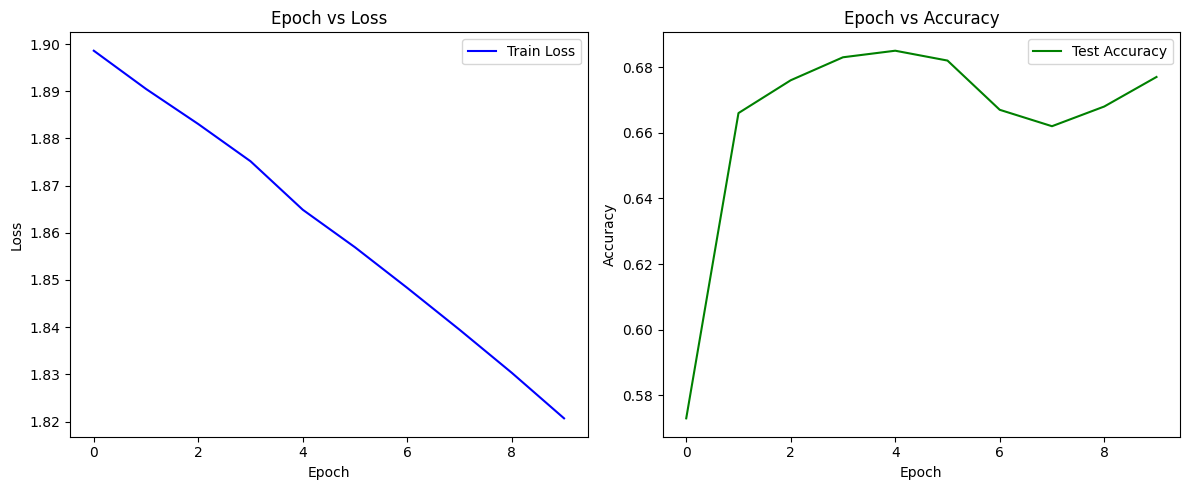

In [20]:
import matplotlib.pyplot as plt

# Plot Epoch vs Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plot Epoch vs Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

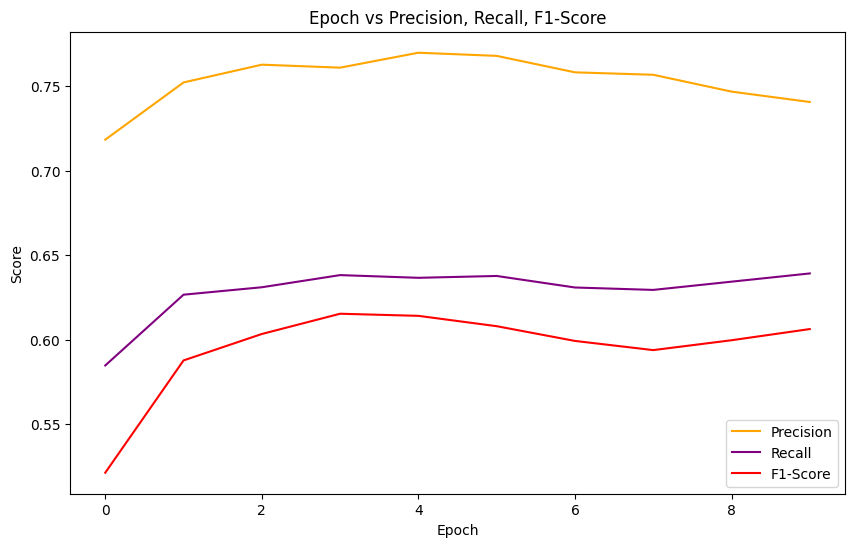

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), precisions, label='Precision', color='orange')
plt.plot(range(num_epochs), recalls, label='Recall', color='purple')
plt.plot(range(num_epochs), f1_scores, label='F1-Score', color='red')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Epoch vs Precision, Recall, F1-Score')
plt.legend()
plt.show()

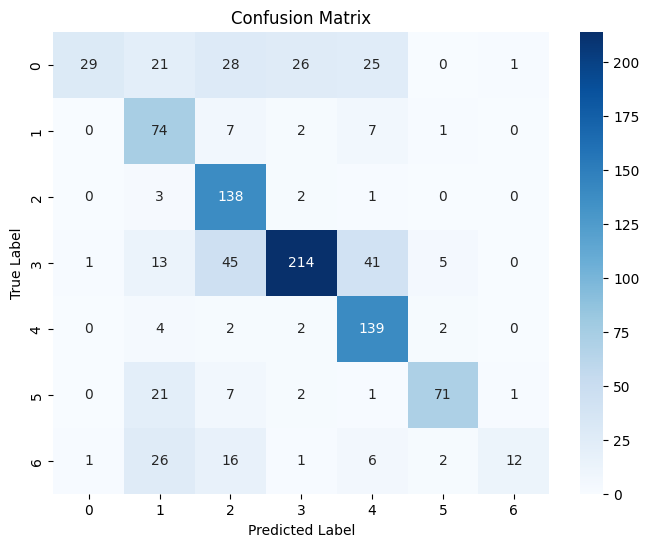


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.22      0.36       130
           1       0.46      0.81      0.58        91
           2       0.57      0.96      0.71       144
           3       0.86      0.67      0.75       319
           4       0.63      0.93      0.75       149
           5       0.88      0.69      0.77       103
           6       0.86      0.19      0.31        64

    accuracy                           0.68      1000
   macro avg       0.74      0.64      0.61      1000
weighted avg       0.76      0.68      0.65      1000


Balanced Accuracy: 0.6393
ROC-AUC Score: 0.9197
Log Loss: 1.8621


In [24]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    roc_auc_score,
    log_loss,
    roc_curve,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Switch to evaluation mode
model.eval()
_, pred = model(data.x,data.edge_index).max(dim=1)  # Get predictions

# Extract test labels and predictions
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_true),
    yticklabels=np.unique(y_true),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")

# ROC-AUC (One-vs-Rest)
if len(np.unique(y_true)) > 2:  # Multiclass case
    y_proba = model(data.x,data.edge_index).softmax(dim=1)[data.test_mask].cpu().detach().numpy()
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
else:  # Binary case
    y_proba = model(data.x,data.edge_index).softmax(dim=1)[:, 1][data.test_mask].cpu().detach().numpy()
    roc_auc = roc_auc_score(y_true, y_proba)

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Log Loss
logloss = log_loss(y_true, y_proba)
print(f"Log Loss: {logloss:.4f}")

In [25]:
import torch
# Save the model
torch.save(model.state_dict(), "model_cora_state.pth")
print("Model state dictionary saved.")

Model state dictionary saved.


In [26]:
!pip install streamlit torch-geometric networkx matplotlib plotly pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [40]:
%%writefile app.py
import streamlit as st
import torch
import pandas as pd
import torch.nn as nn
import plotly.express as px
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

class META_GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second (output) graph convolution layer
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First layer + ReLU activation and dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # Second layer returns logits (no activation)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = META_GNN(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

model.load_state_dict(torch.load("model_cora_state.pth"))
model.eval()
print("Model state dictionary loaded.")

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Use a layout for node positions
pos = nx.spring_layout(G)  # Positions for nodes
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]

# Get predicted classes (assuming predictions are already computed)
_, pred = model(data.x,data.edge_index).max(dim=1)
predicted_classes = pred.cpu().numpy()

# Create a DataFrame for nodes
node_data = pd.DataFrame({
    'x': x_nodes,
    'y': y_nodes,
    'class': predicted_classes
})

# Streamlit App
st.title("Cora Dataset Node Visualization")
st.markdown("Use the multi-select box to filter nodes by class.")

# Multi-select for classes
unique_classes = sorted(node_data['class'].unique())
selected_classes = st.multiselect("Select Classes to Display", unique_classes, default=unique_classes)

# Filter nodes based on selected classes
filtered_data = node_data[node_data['class'].isin(selected_classes)]

# Plot using Plotly
fig = px.scatter(
    filtered_data,
    x='x',
    y='y',
    color='class',
    title="Cora Nodes Colored by Predicted Class",
    color_continuous_scale=px.colors.qualitative.Set1,
    labels={'class': 'Class'}
)

# Customize layout
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True, height=700, width=700)

# Display the graph in Streamlit
st.plotly_chart(fig)

d = data = {
    0: "Neural_Networks",
    1: "Probabilistic_Methods",
    2: "Genetic_Algorithms",
    3: "Theory",
    4: "Case_Based",
    5: "Reinforcement_Learning",
    6: "Rule_Learning"
}

st.write(data)

Overwriting app.py


In [41]:
%%writefile app.py
import streamlit as st
import torch
import pandas as pd
import torch.nn as nn
import plotly.express as px
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

class META_GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second (output) graph convolution layer
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First layer + ReLU activation and dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # Second layer returns logits (no activation)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = META_GNN(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

model.load_state_dict(torch.load("model_cora_state.pth"))
model.eval()
print("Model state dictionary loaded.")

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Use a layout for node positions
pos = nx.spring_layout(G)
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]

# Get predicted classes
_, pred = model(data.x,data.edge_index).max(dim=1)
predicted_classes = pred.cpu().numpy()

# Map class integers to names
class_names = {
    0: "Neural_Networks",
    1: "Probabilistic_Methods",
    2: "Genetic_Algorithms",
    3: "Theory",
    4: "Case_Based",
    5: "Reinforcement_Learning",
    6: "Rule_Learning"
}
predicted_class_names = [class_names[cls] for cls in predicted_classes]

# Create a DataFrame for nodes
node_data = pd.DataFrame({
    'x': x_nodes,
    'y': y_nodes,
    'class': predicted_class_names
})

# Streamlit App
st.title("Cora Dataset Node Visualization")
st.markdown("Use the multi-select box to filter nodes by class.")

# Multi-select for classes
unique_classes = sorted(node_data['class'].unique())
selected_classes = st.multiselect("Select Classes to Display", unique_classes, default=unique_classes)

# Filter nodes based on selected classes
filtered_data = node_data[node_data['class'].isin(selected_classes)]

# Plot using Plotly
fig = px.scatter(
    filtered_data,
    x='x',
    y='y',
    color='class',
    title="Cora Nodes Colored by Predicted Class",
    color_discrete_sequence=px.colors.qualitative.Set1,
    labels={'class': 'Class'}
)

# Customize layout
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True, height=700, width=700)

# Display the graph in Streamlit
st.plotly_chart(fig)


Overwriting app.py


In [42]:
from pyngrok import ngrok

ngrok_key = "2oVc3Q5FQMVrORj72rHxDFTdf27_2gpUiSu8L5hdL7F1drGwg"
port = 8501

ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://e121-34-23-107-67.ngrok-free.app'

In [ ]:
!streamlit run app.py &>/content/logs.txt